In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

In [2]:
dataset = pd.read_csv("creditcard.csv")

In [3]:
#check for any null values
print("Any nulls in the dataset",dataset.isnull().values.any())
print('-------')
print("No. of unique labels",len(dataset['Class'].unique()))
print("Label values",dataset.Class.unique())

#0 is for normal credit card transcation
#1 is for fraudulent credit card transcation
print('-------')
print("Break down of Normal and Fraud Transcations")
print(pd.value_counts(dataset['Class'],sort=True))

Any nulls in the dataset False
-------
No. of unique labels 2
Label values [0 1]
-------
Break down of Normal and Fraud Transcations
Class
0    284315
1       492
Name: count, dtype: int64


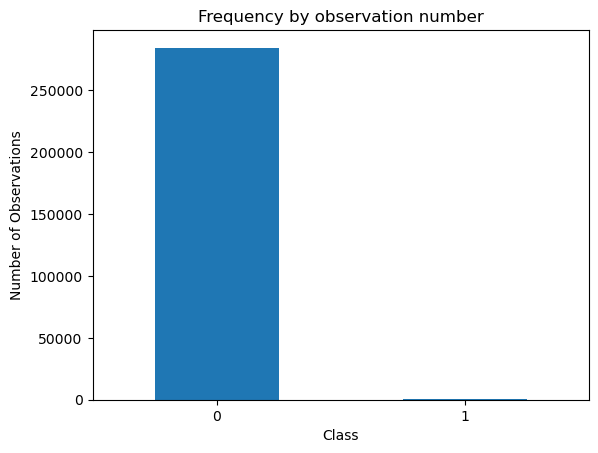

In [4]:
#visualizing the imbalanced dataset
count_classes = pd.value_counts(dataset['Class'],sort=True)
count_classes.plot(kind='bar',rot=0)
plt.xticks(range(len(dataset['Class'].unique())),dataset.Class.unique())
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations")

normal_dataset = dataset[dataset.Class == 0]
fraud_dataset = dataset[dataset.Class == 1]

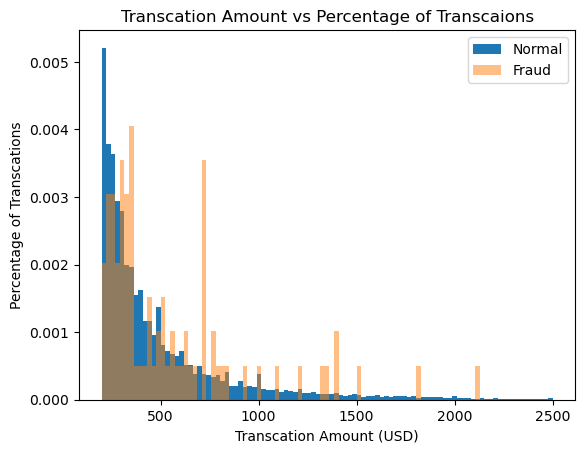

In [5]:
#Save the normal and fradulent transcations in seperate dataframe
normal_dataset = dataset[dataset.Class == 0]
fraud_dataset = dataset[dataset.Class == 1]

#Visualize transcation amounts for normal and fraudulent transcations
bins = np.linspace(200,2500,100)
plt.hist(normal_dataset.Amount,bins=bins,alpha=1,density=True,label='Normal')
plt.hist(fraud_dataset.Amount,bins=bins,alpha=0.5,density=True,label='Fraud')
plt.legend(loc='upper right')
plt.title("Transcation Amount vs Percentage of Transcaions")
plt.xlabel("Transcation Amount (USD)")
plt.ylabel("Percentage of Transcations")
plt.show()

In [9]:
scaler = StandardScaler()
X = scaler.fit_transform(dataset.drop("Class", axis=1))
y = dataset["Class"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Build and train the Autoencoder model
input_dim = X_train.shape[1]

In [12]:
encoder = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu')
])

In [13]:
decoder = models.Sequential([
    layers.Input(shape=(16,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(input_dim, activation='linear')  # Using 'linear' activation for reconstruction
])

In [14]:
# Autoencoder
autoencoder = models.Sequential([ encoder, decoder ])

In [17]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
autoencoder.fit(X_train, X_train, epochs=20, batch_size=32, shuffle=True, validation_data=(X_test, X_test))

Epoch 1/20
7121/7121 [==============================] - 11s 2ms/step - loss: 0.0395 - accuracy: 0.8618 - val_loss: 0.0360 - val_accuracy: 0.8648
Epoch 2/20
7121/7121 [==============================] - 12s 2ms/step - loss: 0.0390 - accuracy: 0.8633 - val_loss: 0.0368 - val_accuracy: 0.8686
Epoch 3/20
7121/7121 [==============================] - 11s 1ms/step - loss: 0.0389 - accuracy: 0.8629 - val_loss: 0.0394 - val_accuracy: 0.8496
Epoch 4/20
7121/7121 [==============================] - 8s 1ms/step - loss: 0.0385 - accuracy: 0.8636 - val_loss: 0.0396 - val_accuracy: 0.8707
Epoch 5/20
7121/7121 [==============================] - 6s 818us/step - loss: 0.0391 - accuracy: 0.8633 - val_loss: 0.0397 - val_accuracy: 0.8651
Epoch 6/20
7121/7121 [==============================] - 5s 730us/step - loss: 0.0390 - accuracy: 0.8655 - val_loss: 0.0347 - val_accuracy: 0.8737
Epoch 7/20
7121/7121 [==============================] - 7s 938us/step - loss: 0.0382 - accuracy: 0.8656 - val_loss: 0.0400 - val_

In [18]:
# Detect anomalies and tune the threshold
y_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - y_pred, 2), axis=1)

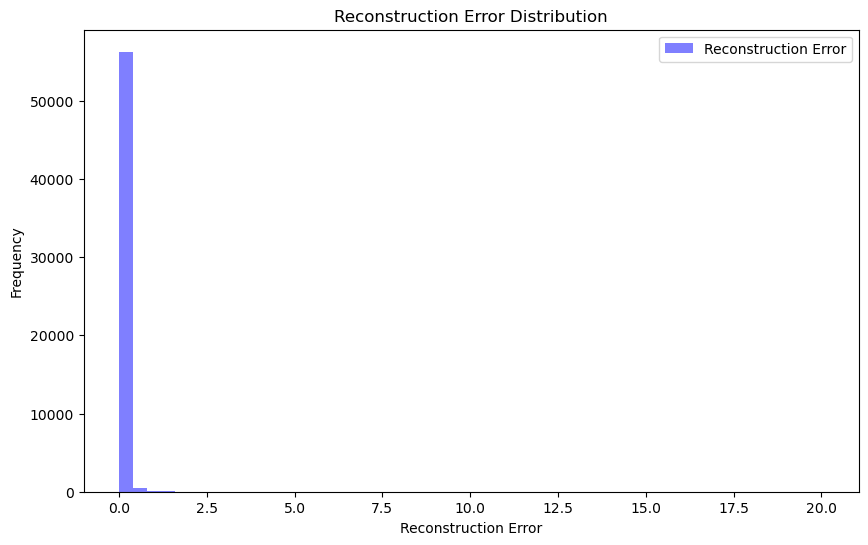

In [19]:
# Visualize the reconstruction error distribution
plt.figure(figsize=(10, 6))
plt.hist(mse, bins=50, alpha=0.5, color='b', label='Reconstruction Error')
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.title("Reconstruction Error Distribution")
plt.show()

In [20]:
# Threshold tuning (iterate and adjust as needed)
thresholds = np.arange(0.1, 1.0, 0.1)  # Adjust the step size as needed

for threshold in thresholds:
    anomalies = mse > threshold

In [21]:
# Count the number of anomalies
num_anomalies = np.sum(anomalies)
print(f"Threshold: {threshold:.1f}, Number of anomalies: {num_anomalies}")

Threshold: 0.9, Number of anomalies: 168


In [22]:
# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, anomalies))

print("\nClassification Report:")
print(classification_report(y_test, anomalies))

Confusion Matrix:
[[56711   153]
 [   83    15]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.09      0.15      0.11        98

    accuracy                           1.00     56962
   macro avg       0.54      0.58      0.56     56962
weighted avg       1.00      1.00      1.00     56962



In [23]:
import seaborn as sns

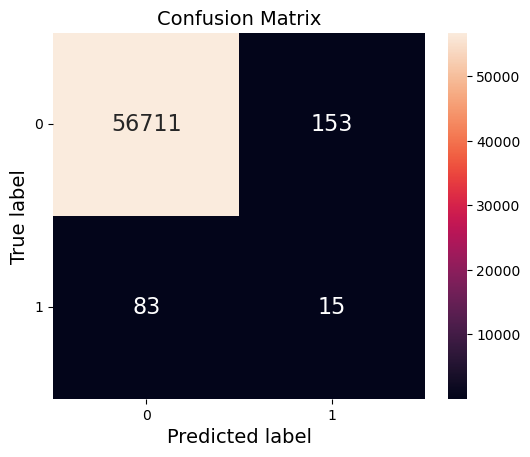

In [24]:
plt.figure(figsize = (6, 4.75))
sns.heatmap(confusion_matrix(y_test, anomalies), annot = True, annot_kws = {"size": 16}, fmt = 'd')
plt.xticks([0.5, 1.5],  rotation = 'horizontal')
plt.yticks([0.5, 1.5],  rotation = 'horizontal')
plt.xlabel("Predicted label", fontsize = 14)
plt.ylabel("True label", fontsize = 14)
plt.title("Confusion Matrix", fontsize = 14)
plt.grid(False)
plt.show()

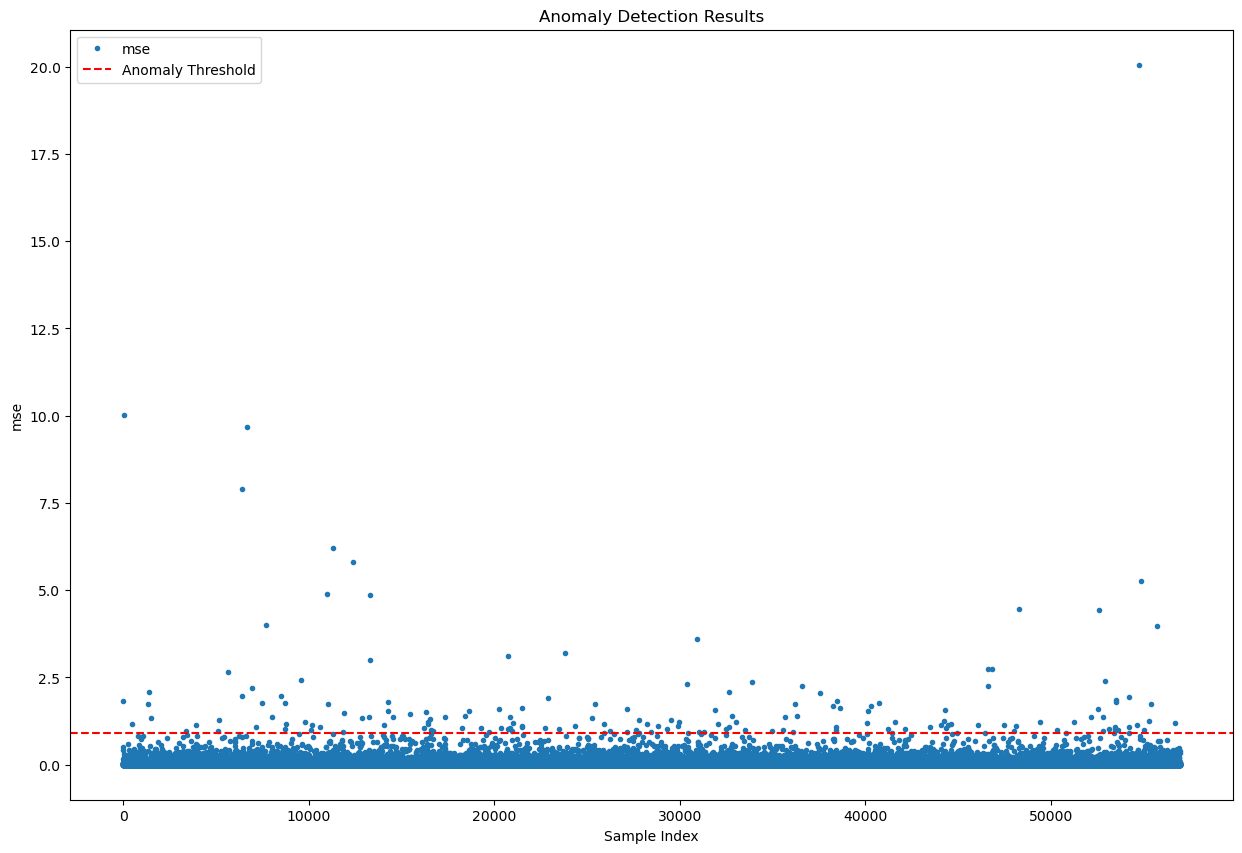

In [26]:
# Plot the anomalies
plt.figure(figsize=(15, 10))
plt.plot(mse, marker='o', linestyle='', markersize=3, label='mse')
plt.axhline(threshold, color='r', linestyle='--', label='Anomaly Threshold')
plt.xlabel('Sample Index')
plt.ylabel('mse')
plt.title('Anomaly Detection Results')
plt.legend()
plt.show()